# Time series forecasing with LSTM model

In this notebook, we will show how to use Analytics Zoo to do time series forecasting.

The dataset we use is the aggregated network traffic traces at the transit link of WIDE to the upstream ISP (You can find the data [here](http://mawi.wide.ad.jp/~agurim/dataset/)). We use its monthly aggregated data of year 2018 and 2019 to do time series forecasting. The monthly aggregated data is collected at 2-hour interval.

To download data, you can run `get_data.sh`. It will download all the monthly aggregated data of 2018 and 2019 into `data`. 

The raw data contains full network traffic logs. To extract values which can indicate network traffic status (eg. `AvgRate` and `total`), you can run `extract_data.sh`. It will extract the useful values into data.csv in your `data` folder. 

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
raw_df = pd.read_csv("data.csv")

In [5]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Data pre-processing should contain the below steps:  
1. Convert string datetime to TimeStamp
2. Unify `AvgRate` value since it contains different scales
3. Drop missing data and fill.

In [6]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [134]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [8]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [9]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [11]:
df.head()

,AvgRate,total
StartTime,,
2018-01-01 00:00:00,306.23,275605455598
2018-01-01 02:00:00,285.03,256527692256
2018-01-01 04:00:00,247.39,222652190823
2018-01-01 06:00:00,211.55,190396029658
2018-01-01 08:00:00,234.82,211340468977


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [12]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
    df = df.reindex(full_idx)
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [145]:
def rm_missing_weeks(start_dts, missing_lens, df):
    # drop weeks that contains more than 3 consecutive missing values.
    # If consecutive missing values across weeks, we remove all the weeks.
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [146]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [17]:
df.ffill(inplace=True)

Visualization  
Note that we remove weeks from 2018-02-12 to 2018-03-11.

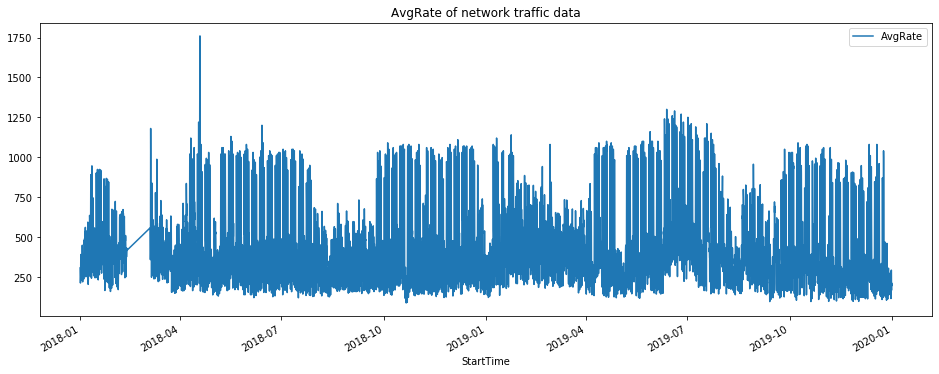

In [141]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

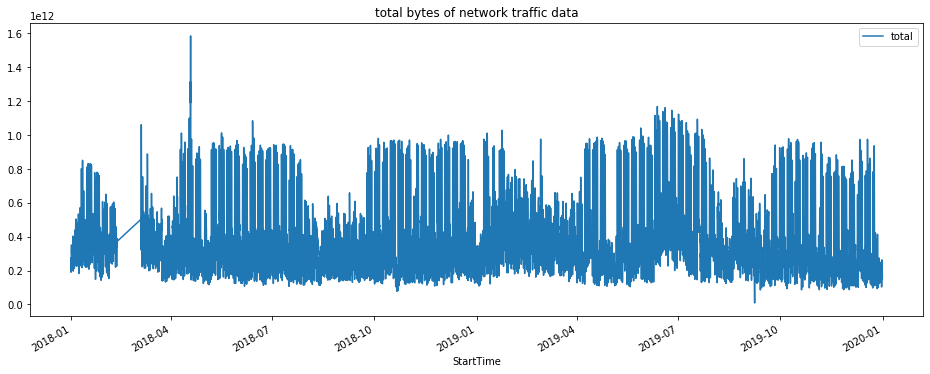

In [142]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering

Let's take AvgRate as an example.

Extract some useful datetime features.

In [23]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["dayofweek"] = df.index.dayofweek
df["hour"] = df.index.hour

In [24]:
df.head()

,AvgRate,total,year,month,week,dayofweek,hour
StartTime,,,,,,,
2018-01-01 00:00:00,306.23,275605455598,2018,1,1,0,0
2018-01-01 02:00:00,285.03,256527692256,2018,1,1,0,2
2018-01-01 04:00:00,247.39,222652190823,2018,1,1,0,4
2018-01-01 06:00:00,211.55,190396029658,2018,1,1,0,6
2018-01-01 08:00:00,234.82,211340468977,2018,1,1,0,8


## Data preparation

First, split dataset into train and test set

In [125]:
test_num = 1000
look_back = 50
test_split_index = test_num + look_back + 1
future_seq_len = 1
target_value = "AvgRate"
target_col_index =0

#train_df
train_df = df[:-test_num]
test_df = df[-test_split_index:]
test_df = test_df.reset_index(drop=True)


Then standardize train, test data and featues

In [112]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate data matrix by sliding window along time axis


In [113]:
def gen_dataset_matrix(dataset, look_back=look_back, future_seq_len=future_seq_len):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i: (i + look_back)])
        Y.append(dataset[(i + look_back): (i + look_back + future_seq_len), 0])
    return np.array(X), np.array(Y)

In [114]:
x_train, y_train = gen_dataset_matrix(scaled_train)
x_test, y_test = gen_dataset_matrix(scaled_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7423, 84, 7), (7423, 1), (1000, 84, 7), (1000, 1))

# Time series forecasting 

 Let's take LSTM model as an example

In [115]:
from zoo.automl.model import VanillaLSTM
from zoo.tfpark import KerasModel

In [151]:
# build model
model = VanillaLSTM(future_seq_len=future_seq_len)._build(input_shape=(x_train.shape[1], x_train.shape[-1]))

keras_model = KerasModel(model)

In [128]:
keras_model.fit(x=x_train, y=y_train, batch_size=32, epochs=20, distributed=False)

Train on 7423 samples
Epoch 1/20
7423/7423 [==============================] - 26s 3ms/sample - loss: 0.6177 - mean_squared_error: 0.6177
Epoch 2/20
7423/7423 [==============================] - 24s 3ms/sample - loss: 0.2619 - mean_squared_error: 0.2619
Epoch 3/20
7423/7423 [==============================] - 25s 3ms/sample - loss: 0.2033 - mean_squared_error: 0.2033
Epoch 4/20
7423/7423 [==============================] - 24s 3ms/sample - loss: 0.1779 - mean_squared_error: 0.1779
Epoch 5/20
7423/7423 [==============================] - 24s 3ms/sample - loss: 0.1580 - mean_squared_error: 0.1580
Epoch 6/20
7423/7423 [==============================] - 24s 3ms/sample - loss: 0.1493 - mean_squared_error: 0.1493
Epoch 7/20
7423/7423 [==============================] - 23s 3ms/sample - loss: 0.1387 - mean_squared_error: 0.1387
Epoch 8/20
7423/7423 [==============================] - 23s 3ms/sample - loss: 0.1323 - mean_squared_error: 0.1323
Epoch 9/20
7423/7423 [==============================] - 24

In [129]:
# make prediction
y_pred = keras_model.predict(x_test)

In [130]:
# unscale y_test and y_pred
# future_seq_len = 1
dummy_feature_shape = standard_scaler.scale_.shape[0]
y_pred_dummy = np.repeat(y_pred, dummy_feature_shape, axis=1)
y_pred_unscale = standard_scaler.inverse_transform(y_pred_dummy)[:,0]
y_test_dummy = np.repeat(y_test, dummy_feature_shape, axis=1)
y_test_unscale = standard_scaler.inverse_transform(y_test_dummy)[:,0]

In [152]:
# evaluate with sMAPE
EPSILON = 1e-10
def sMAPE(y_true, y_pred):
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    return np.mean(output_errors)

sMAPE(y_test_unscale, y_pred_unscale)

7.646085243309382

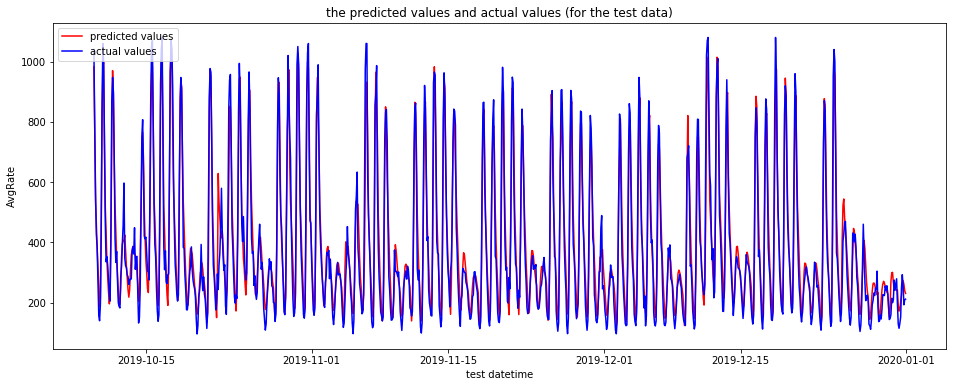

In [138]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots(figsize=(16,6))

test_date=df[-test_num:].index
axs.plot(test_date, y_pred_unscale,color='red', label='predicted values')
axs.plot(test_date, y_test_unscale,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test datetime')
plt.ylabel('AvgRate')
plt.legend(loc='upper left')
plt.show()